[View in Colaboratory](https://colab.research.google.com/github/DongminWu/MLpractice/blob/master/deep_siamese_one_shot_learning.ipynb)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from scipy.stats import norm

from scipy.signal import triang

from sklearn.utils import shuffle

# Data Generating

In [0]:
num_of_each_type = 40
num_of_weekend = 13
day_length = 1440

train_size = 300
test_size = 100

In [0]:
def gaussian_pdf(mu,  sigma, length):
  '''
  mu: mean of the gaussian distribution
  sigma: variance of the gaussian distribution
  
  length: the length of the sequence
  '''
  
  raw_ = np.linspace(-5, 5, length)
  ret = 1/(sigma * np.sqrt(2 * np.pi)) * \
      np.exp( - (raw_ - mu)**2 / (2 * sigma**2))
  return ret

                
  

# Triangle wave

def triangle_pdf(mid, width, length):

  raw_ = np.linspace(-5, 5, length)

  l_mask = mid  - float(width)/2
  l_empty = np.where(raw_ < l_mask)[0]

  ret_l = [0]*len(l_empty)

  r_mask = mid + float(width)/2
  r_empty = np.where(raw_ > r_mask)[0]
  ret_r = [0]*len(r_empty)

  number_mid = length - len(l_empty) - len(r_empty)
  ret_m = triang(number_mid)

  ret = np.concatenate([ret_l, ret_m, ret_r])
  
  return ret

def rect_pdf(mid, width, length):
  raw_ = np.linspace(-5, 5, length)
  l_mask = mid  - float(width)/2
  l_empty = np.where(raw_ < l_mask)[0]

  ret_l = [0]*len(l_empty)

  r_mask = mid + float(width)/2
  r_empty = np.where(raw_ > r_mask)[0]
  ret_r = [0]*len(r_empty)
  
  number_mid = length - len(l_empty) - len(r_empty)
  ret_m = [0.5] * (number_mid)

  ret = np.concatenate([ret_l, ret_m, ret_r])
  
  return ret
  


def random_pdf(prob, max, length):
  raw = [0] * length
  
  for i,each in enumerate(raw):
    r = np.random.random()
    if r < prob:
      raw[i] = np.random.uniform(-max, max)

  return np.array(raw)


def generate_binary(distribution):
  return np.array([np.random.choice( np.array([0,1]),p=[1-p,p]) for p in distribution])

## Train set

In [4]:
# 4 sensors

g1_set = [generate_binary(gaussian_pdf(0,1,day_length)) for i in range(num_of_each_type)]
g2_set = [generate_binary(gaussian_pdf(0,1.3,day_length)) for i in range(num_of_each_type)]
t1_set = [generate_binary(rect_pdf(0,6,day_length)) for i in range(num_of_each_type)]
t2_set = [generate_binary(rect_pdf(0,3,day_length)) for i in range(num_of_each_type)]
empty1_set = [generate_binary(np.clip(random_pdf(0.1, 0.2, day_length),0,1)) for i in range(num_of_weekend)]
empty2_set = [generate_binary(np.clip(random_pdf(0.1, 0.2, day_length),0,1)) for i in range(num_of_weekend)]

g_set = np.concatenate([g1_set, g2_set])
np.random.shuffle(g_set)
g_pair_set = g_set.reshape([-1,2,1440])

t_set = np.concatenate([t1_set, t2_set])
np.random.shuffle(t_set)
t_pair_set = t_set.reshape([-1,2,1440])

empty_set = np.concatenate([empty1_set, empty2_set])
np.random.shuffle(empty_set)
empty_pair_set = empty_set.reshape([-1,2,1440])


tX = []
tY = []
for i in range(train_size // 2 *3):
  first_set = np.random.choice([t_set, g_set, empty_set])
  second_set = np.random.choice([t_set, g_set, empty_set])
  first_idx = np.random.choice(first_set.shape[0]-1)
  second_idx = np.random.choice(second_set.shape[0]-1)
  sample = np.array([first_set[first_idx], second_set[second_idx]] )
  tX.append(sample)
  y = 1 if first_set is second_set else 0
  tY.append(y)

tmpX = np.stack(tX)
tmpY = np.array(tY).reshape(-1,1)

n_neighbor = (tmpY==1).sum()
idx_neighbor = np.where(tmpY==1)[0]
idx_non_neighbor = np.random.choice(np.where(tmpY==0)[0], n_neighbor)

trainX = tmpX[list(idx_neighbor)+list(idx_non_neighbor)]
trainY = tmpY[list(idx_neighbor)+list(idx_non_neighbor)]


trainX, trainY = shuffle(trainX, trainY)
trainX = trainX[:,:,:,None]
print("trainX", trainX.shape)
print("trainY", trainY.shape)
print("# of neighbor:", (trainY==1).sum())

trainX (334, 2, 1440, 1)
trainY (334, 1)
# of neighbor: 167


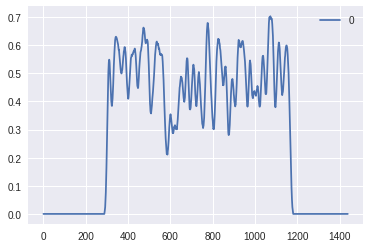

In [5]:
pd.DataFrame(generate_binary(rect_pdf(0,6,day_length))).rolling(30, win_type='hamming').mean().fillna(0).plot()

## Test Set

The difference is the mean and variance of each waveform


In [6]:
# 4 sensors

g1_set = [generate_binary(gaussian_pdf(0,1,day_length)) for i in range(num_of_each_type)]
g2_set = [generate_binary(gaussian_pdf(0,1.5,day_length)) for i in range(num_of_each_type)]
t1_set = [generate_binary(rect_pdf(0,2,day_length)) for i in range(num_of_each_type)]
t2_set = [generate_binary(rect_pdf(0,8,day_length)) for i in range(num_of_each_type)]
empty1_set = [generate_binary(np.clip(random_pdf(0.1, 0.2, day_length),0,1)) for i in range(num_of_weekend)]
empty2_set = [generate_binary(np.clip(random_pdf(0.1, 0.2, day_length),0,1)) for i in range(num_of_weekend)]

g_set = np.concatenate([g1_set, g2_set])
np.random.shuffle(g_set)
g_pair_set = g_set.reshape([-1,2,1440])

t_set = np.concatenate([t1_set, t2_set])
np.random.shuffle(t_set)
t_pair_set = t_set.reshape([-1,2,1440])

empty_set = np.concatenate([empty1_set, empty2_set])
np.random.shuffle(empty_set)
empty_pair_set = empty_set.reshape([-1,2,1440])


tX = []
tY = []
for i in range(test_size // 2 *3):
  first_set = np.random.choice([t_set, g_set, empty_set])
  second_set = np.random.choice([t_set, g_set, empty_set])
  first_idx = np.random.choice(first_set.shape[0]-1)
  second_idx = np.random.choice(second_set.shape[0]-1)
  sample = np.array([first_set[first_idx], second_set[second_idx]] )
  tX.append(sample)
  y = 1 if first_set is second_set else 0
  tY.append(y)

tmpX = np.stack(tX)
tmpY = np.array(tY).reshape(-1,1)

n_neighbor = (tmpY==1).sum()
idx_neighbor = np.where(tmpY==1)[0]
idx_non_neighbor = np.random.choice(np.where(tmpY==0)[0], n_neighbor)

testX = tmpX[list(idx_neighbor)+list(idx_non_neighbor)]
testY = tmpY[list(idx_neighbor)+list(idx_non_neighbor)]


testX, testY = shuffle(testX, testY)
testX = testX[:,:,:,None]
print("testX", testX.shape)
print("testY", testY.shape)
print("# of neighbor:", (testY==1).sum())

testX (112, 2, 1440, 1)
testY (112, 1)
# of neighbor: 56


[0]


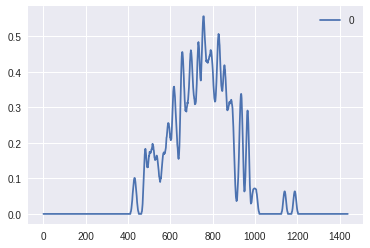

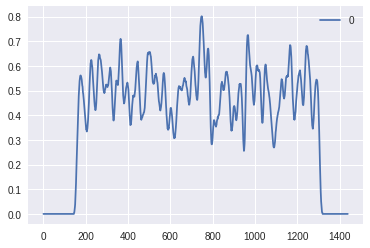

In [7]:
pd.DataFrame(testX[54,0,:,0]).rolling(30, win_type="hamming").mean().fillna(0).plot()
pd.DataFrame(testX[54,1,:,0]).rolling(30, win_type="hamming").mean().fillna(0).plot()
print(testY[54])

# model building


## 1D-CNN

In [0]:
dim_dense = 32

dropout_rate = 0.2
regularizer_coef = 0.01
rolling_window = 30

In [9]:
trX = np.zeros(trainX.shape)
teX = np.zeros(testX.shape)

print("trainX shape:", trainX.shape )

for s in range(trainX.shape[0]):
  for i in range(trainX.shape[1]):
    tmp = pd.DataFrame(trainX[s,i,:,0]).rolling(rolling_window, win_type='hamming').mean().fillna(0)
    trX[s,i,:,:]=tmp.as_matrix()
 

print("testX shape:", testX.shape )

for s in range(testX.shape[0]):
  for i in range(testX.shape[1]):
    tmp = pd.DataFrame(testX[s,i,:,0]).rolling(rolling_window, win_type='hamming').mean().fillna(0)
    teX[s,i,:,:]=tmp.as_matrix()
  

trainX shape: (334, 2, 1440, 1)
testX shape: (112, 2, 1440, 1)


In [0]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Input, Dense, Lambda
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import Model

In [27]:


input_l = Input(shape=(day_length, 1), name = 'input_layer_l')
input_r = Input(shape=(day_length, 1), name = 'input_layer_r')

conv_1_l = Conv1D(64, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_1_l")(input_l)
conv_1_r = Conv1D(64, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_1_r")(input_r)

pool_1_l = MaxPooling1D(pool_size=2, name="pool_1_l")(conv_1_l)
pool_1_r= MaxPooling1D(pool_size=2, name="pool_1_r")(conv_1_r)

drop_1_l = Dropout(dropout_rate)(pool_1_l)
drop_1_r = Dropout(dropout_rate)(pool_1_r)


conv_2_l = Conv1D(32, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_3_l")(drop_1_l)
conv_2_r = Conv1D(32, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_3_r")(drop_1_r)

pool_2_l = MaxPooling1D(pool_size=2, name="pool_4_l")(conv_2_l)
pool_2_r= MaxPooling1D(pool_size=2, name="pool_4_r")(conv_2_r)

drop_2_l = Dropout(dropout_rate)(pool_2_l)
drop_2_r = Dropout(dropout_rate)(pool_2_r)

conv_3_l = Conv1D(16, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_5_l")(drop_2_l)
conv_3_r = Conv1D(16, kernel_size=5, kernel_regularizer=l2(regularizer_coef), name="conv_5_r")(drop_2_r)

pool_3_l = MaxPooling1D(pool_size=2, name="pool_6_l")(conv_3_l)
pool_3_r= MaxPooling1D(pool_size=2, name="pool_6_r")(conv_3_r)

drop_3_l = Dropout(dropout_rate)(pool_3_l)
drop_3_r = Dropout(dropout_rate)(pool_3_r)


flat_l = Flatten(name="flat_l")(drop_3_l)
flat_r = Flatten(name="flat_r")(drop_3_r)

dense_7_l = Dense(dim_dense, name="dense_7_l")(flat_l)
dense_7_r = Dense(dim_dense, name="dense_7_r")(flat_r)



L1_distance = lambda x: K.abs(x[0]-x[1])

both = Lambda(L1_distance, output_shape=lambda x: x[0])([dense_7_l, dense_7_r])
# both = merge([flat1, flat2], mode=L1_distance, output_shape=lambda x: x[0])

prediction = Dense(1,activation='sigmoid', name="output")(both)


model = Model([input_l, input_r], prediction)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_l (InputLayer)      (None, 1440, 1)      0                                            
__________________________________________________________________________________________________
input_layer_r (InputLayer)      (None, 1440, 1)      0                                            
__________________________________________________________________________________________________
conv_1_l (Conv1D)               (None, 1436, 64)     384         input_layer_l[0][0]              
__________________________________________________________________________________________________
conv_1_r (Conv1D)               (None, 1436, 64)     384         input_layer_r[0][0]              
__________________________________________________________________________________________________
pool_1_l (

In [0]:
model.compile("adam", loss="binary_crossentropy", metrics=['acc'])

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]
model.reset_states()

In [63]:
# for i in range(30):
#   print("=========> epoch:", i)
history = model.fit([trX[:,0,:,:],trX[:,1,:,:] ], trainY, 
                    epochs=50, 
                    callbacks = callbacks_list,
                    batch_size = 2,
                    validation_split=0.2
#                     validation_data=([teX[:,0,:,:],teX[:,1,:,:]], testY)
                   )
  

Train on 267 samples, validate on 67 samples
Epoch 1/50
267/267 [==============================] - 4s 14ms/step - loss: 6.6034 - acc: 0.5618 - val_loss: 5.5116 - val_acc: 0.6567
Epoch 2/50
267/267 [==============================] - 3s 10ms/step - loss: 3.8656 - acc: 0.6330 - val_loss: 0.3668 - val_acc: 0.9104
Epoch 3/50
267/267 [==============================] - 3s 10ms/step - loss: 0.1999 - acc: 0.9476 - val_loss: 0.2572 - val_acc: 0.9552
Epoch 4/50
267/267 [==============================] - 3s 10ms/step - loss: 0.0795 - acc: 0.9888 - val_loss: 0.0362 - val_acc: 1.0000
Epoch 5/50
267/267 [==============================] - 3s 9ms/step - loss: 0.0358 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 1.0000
Epoch 6/50
 38/267 [===>..........................] - ETA: 2s - loss: 0.0336 - acc: 1.0000

267/267 [==============================] - 3s 10ms/step - loss: 0.0321 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 1.0000
Epoch 7/50
267/267 [==============================] - 3s 10ms/step - loss: 0.0297 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 1.0000
Epoch 00007: early stopping


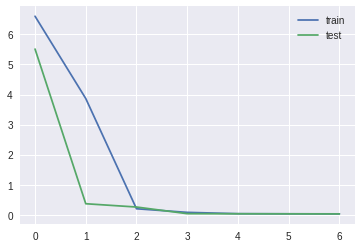

In [64]:
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="test")
plt.legend()



In [65]:
model.evaluate(x = [testX[:,0,:,:],testX[:,1,:,:]], y = testY)

112/112 [==============================] - 0s 424us/step


[0.6928123560334954, 0.875]

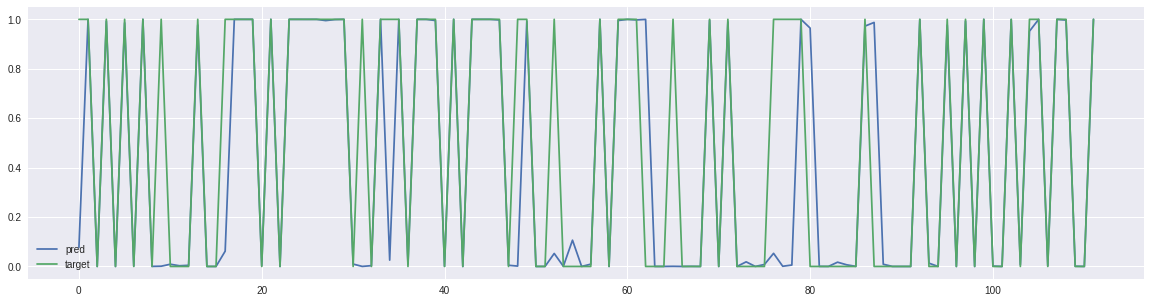

In [66]:
preds = model.predict([teX[:,0,:,:],teX[:,1,:,:]])
plt.figure(figsize=(20,5))
plt.plot(preds, label = "pred")
plt.plot(testY, label = 'target')
plt.legend()

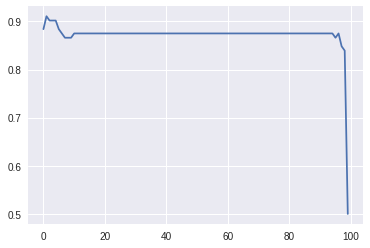

In [67]:
acc = []

for i in range(100):
  thres = (i+1)/100
  new_pred = preds.copy()
  new_pred[new_pred<thres] = 0
  new_pred[new_pred>=thres] = 1

  err = (new_pred != testY).sum()
  acc.append((len(testY)-err)/len(testY))

plt.plot(acc)

In [68]:
np.max(acc)

0.9107142857142857

In [69]:
np.argmax(acc)

1

In [0]:
thres = 0.62

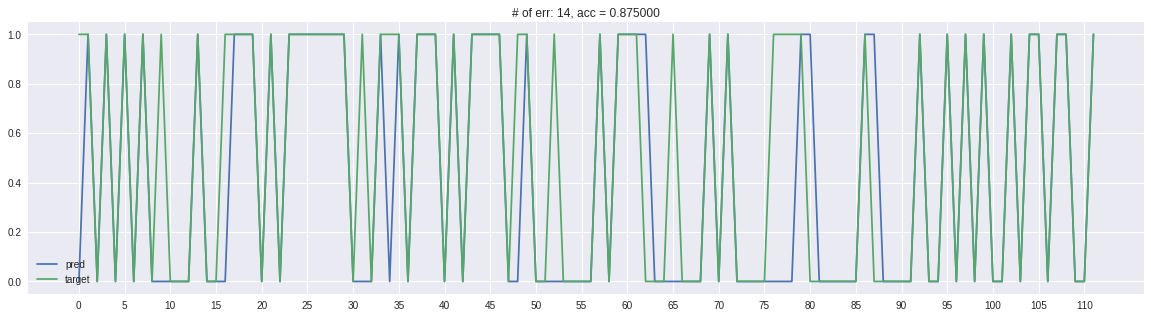

In [71]:
new_pred = preds.copy()
new_pred[new_pred<thres] = 0
new_pred[new_pred>=thres] = 1

err = (new_pred != testY).sum()

plt.figure(figsize=(20,5))
plt.plot(new_pred, label = "pred")
plt.plot(testY, label = 'target')
plt.title("# of err: %d, acc = %f" % (err, (len(testY)-err)/len(testY)))
plt.legend()
plt.xticks(range(0, len(testY),5))
plt.show()

In [72]:
np.where(testY==0)[0]

array([  2,   4,   6,   8,  10,  11,  12,  14,  15,  20,  22,  30,  32,
        36,  40,  42,  47,  50,  51,  53,  54,  55,  56,  58,  62,  63,
        64,  66,  67,  68,  70,  72,  73,  74,  75,  80,  81,  82,  83,
        84,  85,  87,  88,  89,  90,  91,  93,  94,  96,  98, 100, 101,
       103, 106, 109, 110])

In [0]:
num_sample = 16


Text(0.5,1,'pred: 0.000254, target: 1')

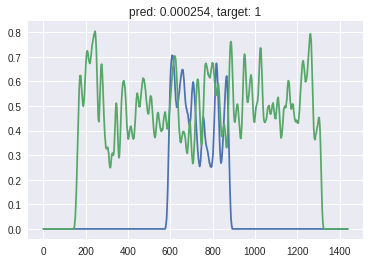

In [77]:
pred = model.predict([teX[num_sample,1,:,:][None,:,:],teX[num_sample,0,:,:][None,:,:]])

plt.plot(teX[num_sample,0,:,0])
plt.plot(teX[num_sample,1,:,0])
plt.title("pred: %f, target: %d" % (pred, testY[num_sample]))

comparing with MSE


In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error


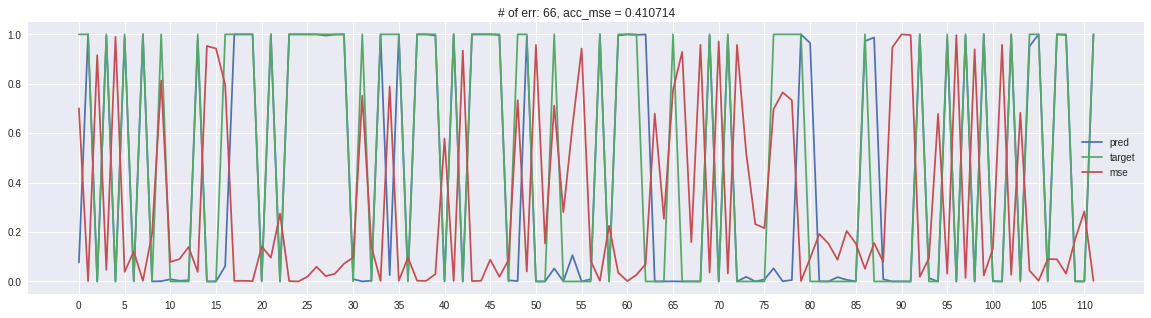

In [83]:
mse = []

for s in range(testX.shape[0]):
  mse.append(mean_squared_error(teX[s,0,:,0],teX[s,1,:,0]))

mse = np.array(mse)  
max_mse = np.max(mse)
mse = mse / max_mse

mse_pred = mse.copy()
mse_pred[mse_pred<thres] = 0
mse_pred[mse_pred>=thres] = 1

n_err_mse = (mse_pred != testY.flatten()).sum()

plt.figure(figsize=(20,5))
plt.plot(preds, label = "pred")
plt.plot(testY, label = 'target')
# plt.plot(mse_pred, label = "mse_pred")
plt.plot(mse, label = "mse")


plt.title("# of err: %d, acc_mse = %f" % (n_err_mse, (len(testY)-n_err_mse)/len(testY)))
plt.legend()
plt.xticks(range(0, len(testY),5))
plt.show()

comparing with from `scipy.stats import wasserstein_distance`

In [80]:
!pip install scipy --upgrade

Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.1.0)
Requirement not upgraded as not directly required: numpy>=1.8.2 in /usr/local/lib/python3.6/dist-packages (from scipy) (1.14.3)


In [0]:
from scipy.stats import wasserstein_distance

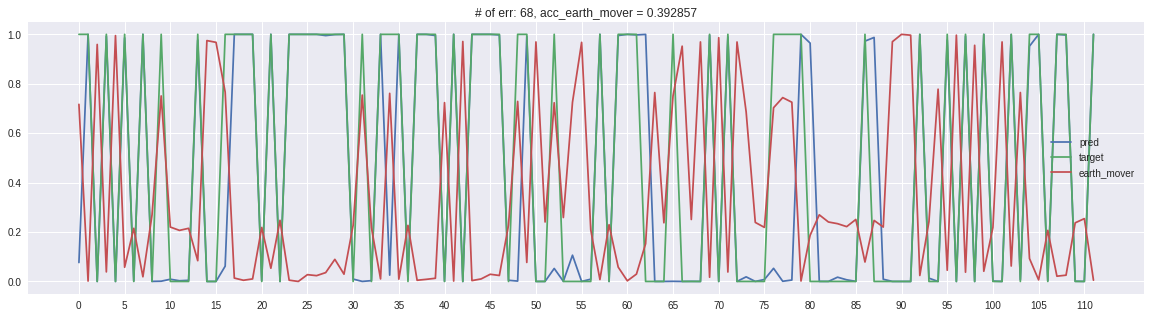

In [82]:
earth_mover = []

for s in range(testX.shape[0]):
  earth_mover.append(wasserstein_distance(teX[s,0,:,0],teX[s,1,:,0]))

earth_mover = np.array(earth_mover)  
max_earth_mover = np.max(earth_mover)
earth_mover = earth_mover / max_earth_mover

earth_mover_pred = earth_mover.copy()
earth_mover_pred[earth_mover_pred<thres] = 0
earth_mover_pred[earth_mover_pred>=thres] = 1

n_err_earth_mover = (earth_mover_pred != testY.flatten()).sum()

plt.figure(figsize=(20,5))
plt.plot(preds, label = "pred")
plt.plot(testY, label = 'target')
# plt.plot(earth_mover_pred, label = "earth_mover_pred")
plt.plot(earth_mover, label = "earth_mover")


plt.title("# of err: %d, acc_earth_mover = %f" % (n_err_earth_mover, (len(testY)-n_err_earth_mover)/len(testY)))
plt.legend()
plt.xticks(range(0, len(testY),5))
plt.show()